In [37]:
import pandas as pd
import numpy as np
import sqlite3
import sys
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors


engine = create_engine("sqlite:///courses_2.db")
courses = pd.read_sql('''
SELECT * FROM courses;''', engine)

courses.dropna(subset=['satisfaction'],inplace=True)


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 


def diagnostic_plots(y_pred, y_true, resid, filestr):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();
    fig.savefig(filestr,dpi=200);

In [39]:
X_train_val, X_test, y_train_val, y_test = train_test_split(courses[[
    'teaching_1',
    'teaching_2',
    'teaching_3',
    'teaching_4',
    'opportunities_1',
    'opportunities_2',
    'opportunities_3',
    'feedback_1',
    'feedback_2',
    'feedback_3',
    'feedback_4',
    'support_1',
    'support_2',
    'support_3',
    'management_1',
    'management_2',
    'management_3',
    'resources_1',
    'resources_2',
    'resources_3',
    'community_1',
    'community_2',
    'voice_1',
    'voice_2',
    'voice_3',
    'voice_4',#33
]], courses['satisfaction'], test_size=0.2,random_state=42)

# Simple Linear Regression

In [40]:
linear_model = LinearRegression()
linear_model.fit(X_train_val,y_train_val)
list(zip(X_train_val.columns, linear_model.coef_))

[('teaching_1', 0.2269055683335416),
 ('teaching_2', 0.07649469423303631),
 ('teaching_3', 0.15390162637598484),
 ('teaching_4', 0.12859173822345402),
 ('opportunities_1', 0.07226080727700594),
 ('opportunities_2', 0.07698856775798119),
 ('opportunities_3', -0.0011329752358839214),
 ('feedback_1', -0.03035488114250536),
 ('feedback_2', 0.043122048592981396),
 ('feedback_3', -0.027222405486447193),
 ('feedback_4', -0.031883212783018956),
 ('support_1', 0.049667802045935884),
 ('support_2', 0.07365648952500374),
 ('support_3', -0.003105379683050779),
 ('management_1', 0.18471168322504342),
 ('management_2', -0.016793803628290065),
 ('management_3', 0.051827391117325636),
 ('resources_1', 0.04930677875618184),
 ('resources_2', -0.0044788770639158345),
 ('resources_3', 0.03657538185384848),
 ('community_1', 0.013702077421719673),
 ('community_2', 0.003069516785027871),
 ('voice_1', 0.02346733474891317),
 ('voice_2', 0.023356853296856796),
 ('voice_3', 0.010891061182253086),
 ('voice_4', -0

In [41]:
linear_model.score(X_test,y_test)

0.736650715754039

In [42]:
# Make predictions on the test set using the new model
test_set_pred = linear_model.predict(X_test)

In [43]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.262890578772139

In [44]:
r2_score(y_test, test_set_pred)

0.736650715754039

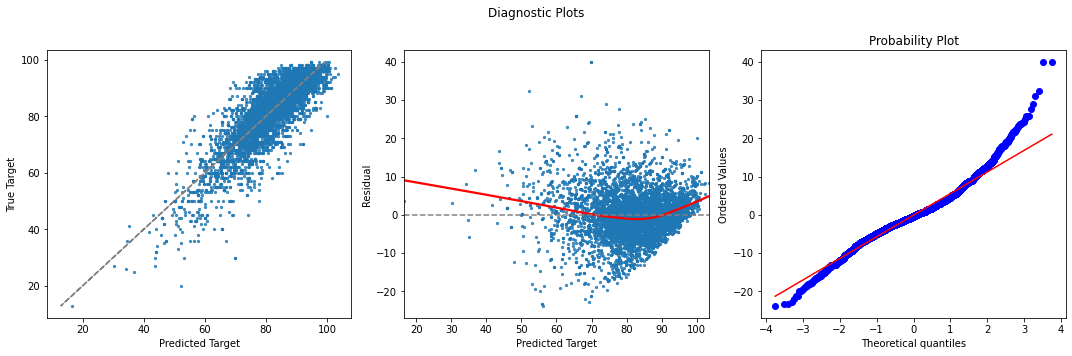

In [36]:
diagnostic_plots(test_set_pred, y_test, test_set_pred-y_test,'linear_all_diagnostic')

In [63]:
poly_features = PolynomialFeatures(2).fit_transform(X_train_val)
linear_model.fit(poly_features,y_train_val)

LinearRegression()

In [64]:
linear_model.score(PolynomialFeatures(2).fit_transform(X_test),y_test)

0.7662201696145187

In [65]:
# Make predictions on the test set using the new model
test_set_pred = linear_model.predict(PolynomialFeatures(2).fit_transform(X_test))

In [66]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

3.953700759032425

# Lasso

In [67]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val.values)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val.values)
X_te = std.transform(X_test.values)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = np.logspace(-2,2,800)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val);

In [68]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
lasso_model.alpha_

0.010593300427523858

In [69]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, lasso_model.coef_))

[('teaching_1', 1.890754648835951),
 ('teaching_2', 0.827623040554054),
 ('teaching_3', 1.5955941009029146),
 ('teaching_4', 1.3378251111816062),
 ('opportunities_1', 0.6862510298373025),
 ('opportunities_2', 0.6898226265442902),
 ('opportunities_3', 0.0),
 ('feedback_1', -0.3672602324179626),
 ('feedback_2', 0.5238355786549921),
 ('feedback_3', -0.413609883921392),
 ('feedback_4', -0.41901461278741026),
 ('support_1', 0.4604508118526259),
 ('support_2', 0.8322808133063267),
 ('support_3', -0.0),
 ('management_1', 3.147716601681681),
 ('management_2', -0.1763462915597345),
 ('management_3', 0.6698105129053669),
 ('resources_1', 0.5069437707542092),
 ('resources_2', -0.018858673525297593),
 ('resources_3', 0.3245213981293911),
 ('community_1', 0.1793542748222953),
 ('community_2', 0.02996688296622084),
 ('voice_1', 0.22059233334561285),
 ('voice_2', 0.2908942537834183),
 ('voice_3', 0.15550714561650694),
 ('voice_4', -0.07716840814311131)]

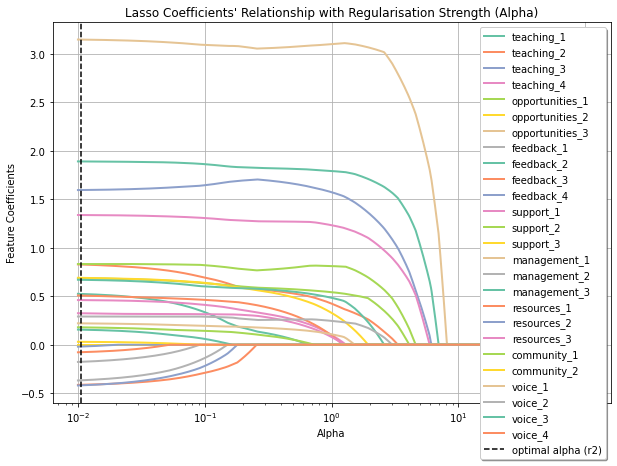

In [70]:

# #############################################################################
# Compute paths


coefs = []
for a in alphavec:
    lasso = Lasso(alpha=a)
    lasso.fit(X_tr, y_train_val)
    coefs.append(lasso.coef_)

# #############################################################################
# Display results
plt.figure(figsize=(10,7))
plt.grid()
ax = plt.gca()
ax.set_prop_cycle(color=sns.color_palette("Set2", 8))
ax.plot(alphavec, coefs,**{'linewidth':2})
plt.axvline(x=lasso_model.alpha_,**{'color':'black','linestyle':'--'})

ax.legend(list(X_train_val.columns)+['optimal alpha (r2)'],shadow=True)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::])  # reverse axis
plt.xlabel('Alpha')
plt.ylabel('Feature Coefficients')
plt.title('Lasso Coefficients\' Relationship with Regularisation Strength (Alpha)')
plt.axis('tight')
plt.savefig('lasso_path_all.png',dpi=200)
plt.show()

In [71]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [72]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.2631065712946405

In [73]:
r2_score(y_test, test_set_pred)

0.7366560213150894

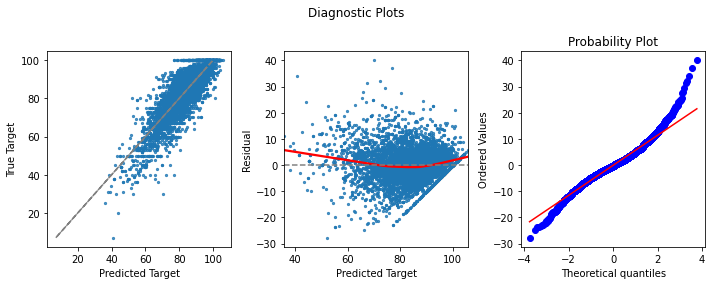

In [78]:
diagnostic_plots(test_set_pred, y_test, test_set_pred-y_test)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 6.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 7.000e+00, 1.000e+00, 1.000e+00,
        1.500e+01, 9.000e+00, 8.000e+00, 1.000e+01, 2.000e+00, 1.000e+01,
        3.000e+01, 3.000e+00, 3.400e+01, 2.100e+01, 3.800e+01, 1.000e+01,
        3.400e+01, 4.100e+01, 5.200e+01, 6.800e+01, 3.100e+01, 2.000e+01,
        2.800e+01, 9.000e+00, 1.610e+02, 3.000e+00, 3.700e+01, 7.300e+01,
        9.700e+01, 1.220e+02, 9.100e+01, 8.500e+01, 1.080e+02, 1.300e+02,
        3.300e+02, 1.210e+02, 2.260e+02, 1.750e+02, 4.930e+02, 2.190e+02,
        1.310e+02, 3.730e+02, 2.650e+02, 4.860e+02, 5.140e+02, 6.690e+02,
        5.120e+02, 8.560e+02, 1.083e+03, 1.155e+03, 9.060e+02, 8.680e+02,
        6.760e+02, 1.163e+03, 1.564e+0

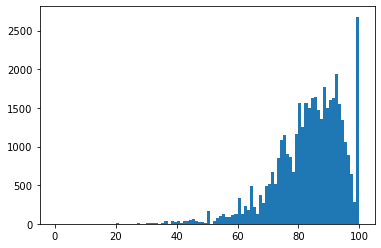

In [27]:
plt.hist(courses['satisfaction'],bins=100)

# Ridge

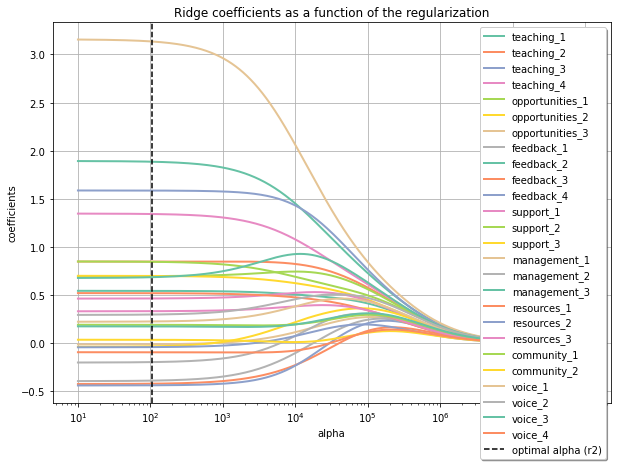

In [29]:

# #############################################################################
# Compute paths

alphas = np.logspace(1, 8, 400)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_tr, y_train_val)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results
plt.figure(figsize=(10,7))
plt.grid()
ax = plt.gca()
ax.set_prop_cycle(color=sns.color_palette("Set2", 8))
ax.plot(alphas, coefs,**{'linewidth':2})
plt.axvline(x=ridge_model.alpha_,**{'color':'black','linestyle':'--'})


ax.legend(list(X_train_val.columns)+['optimal alpha (r2)'],shadow=True)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')




plt.show()


In [23]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(1,7,400)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

RidgeCV(alphas=array([1.00000000e+01, 1.03523178e+01, 1.07170483e+01, 1.10946289e+01,
       1.14855124e+01, 1.18901674e+01, 1.23090791e+01, 1.27427499e+01,
       1.31916996e+01, 1.36564666e+01, 1.41376081e+01, 1.46357012e+01,
       1.51513429e+01, 1.56851516e+01, 1.62377674e+01, 1.68098528e+01,
       1.74020937e+01, 1.80152004e+01, 1.86499079e+01, 1.93069773e+01,
       1.99871964e+01, 2.06913808e+0...
       4.50957214e+06, 4.66845237e+06, 4.83293024e+06, 5.00320295e+06,
       5.17947468e+06, 5.36195677e+06, 5.55086803e+06, 5.74643497e+06,
       5.94889208e+06, 6.15848211e+06, 6.37545637e+06, 6.60007502e+06,
       6.83260739e+06, 7.07333228e+06, 7.32253834e+06, 7.58052437e+06,
       7.84759970e+06, 8.12408458e+06, 8.41031051e+06, 8.70662068e+06,
       9.01337039e+06, 9.33092744e+06, 9.65967258e+06, 1.00000000e+07]),
        cv=5)

In [24]:
# This is the best alpha value it found - not far from the value
# selected using simple validation
ridge_model.alpha_

105.3310445370937

In [25]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train_val.columns, ridge_model.coef_))

[('teaching_1', 1.8856416090892127),
 ('teaching_2', 0.8486262947683917),
 ('teaching_3', 1.5860675336798946),
 ('teaching_4', 1.3424387447357724),
 ('opportunities_1', 0.6971508479956665),
 ('opportunities_2', 0.6989260594162368),
 ('opportunities_3', -0.010829216084594166),
 ('feedback_1', -0.38878892062411685),
 ('feedback_2', 0.5438191807245457),
 ('feedback_3', -0.420745514109949),
 ('feedback_4', -0.43742493277528377),
 ('support_1', 0.46479017660664806),
 ('support_2', 0.8458780476775631),
 ('support_3', -0.03301970377087437),
 ('management_1', 3.134907793332048),
 ('management_2', -0.19625254771644288),
 ('management_3', 0.6859406071880471),
 ('resources_1', 0.5198440750086951),
 ('resources_2', -0.040549046314401566),
 ('resources_3', 0.33272982553063624),
 ('community_1', 0.1911650956236305),
 ('community_2', 0.03548984766392486),
 ('voice_1', 0.2258572940344465),
 ('voice_2', 0.29773700613566445),
 ('voice_3', 0.17447858125798804),
 ('voice_4', -0.09392427642287157)]

In [26]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [27]:
# Find the MAE and R^2 on the test set using this model
mae(y_test, test_set_pred)

4.263311145450216

In [28]:
r2_score(y_test, test_set_pred)

0.7366440830210359